In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import sys
from pathlib import Path
import os

# Get the absolute path of the current notebook's directory
notebook_path = Path(os.getcwd())  # This is /Users/test/Documents/code/iccs25/notebooks
project_root = notebook_path.parent  # This should be /Users/test/Documents/code/iccs25

print(f"Notebook path: {notebook_path}")
print(f"Project root: {project_root}")
print(f"Project root exists: {project_root.exists()}")

# Add to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

# Verify it's added
print(f"Project root now in sys.path: {str(project_root) in sys.path}")


Notebook path: /Users/test/Documents/code/iccs25/notebooks
Project root: /Users/test/Documents/code/iccs25
Project root exists: True
Added /Users/test/Documents/code/iccs25 to sys.path
Project root now in sys.path: True


In [ ]:
# """installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


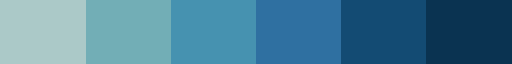

In [ ]:
import scicolor

scicolor.get_cmap("Hokusai2")


In [ ]:
from pathlib import Path

# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
import matplotlib.pyplot as plt

from scripts.preprocesser.constants import (
    START_YEAR,
    MONTHS_IN_YEAR,
    CONST_BASE_DEMAND,
    transport_modes,
    transport_modes_color,
    service_radius_minutes,
    transport_mode_name_mapper,
    service_list,
    threshold,
)

from tqdm import tqdm

tqdm.pandas()


In [ ]:
from scripts.calculator.calculator_this_pipeline import make_block_scheme


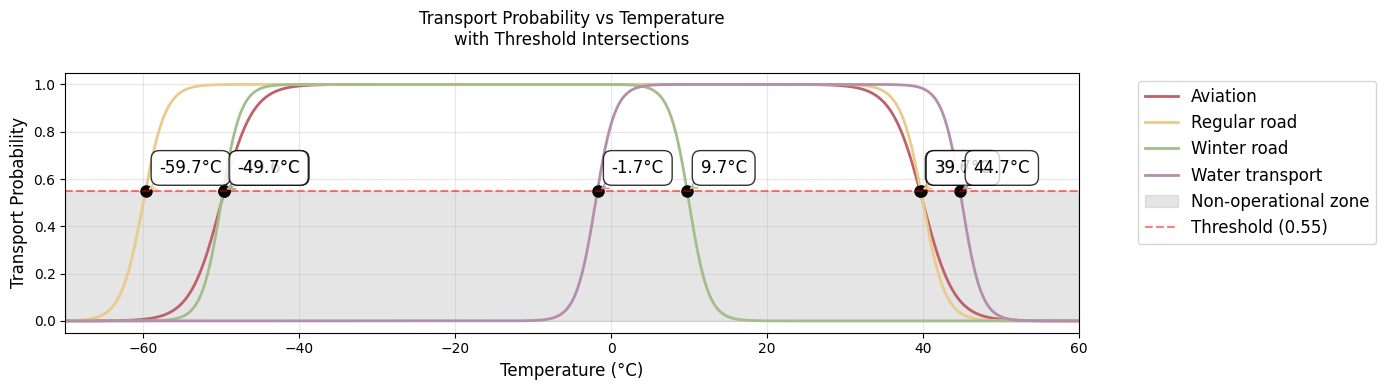

In [ ]:
from scripts.plotter.plotter_transport_mode_prob import (
    plot_transport_probability_legacy,
)
from scripts.calculator.calculator_transport_prob import get_transport_probability

threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


In [ ]:
from scripts.preprocesser.preprocesser import get_data
from scripts.preprocesser.gcreator import make_g, add_temp_to_g
from scripts.plotter.plotter_network_basic import plot_transport_graph
from scripts.preprocesser.huston import call_nasa
from scripts.calculator.calculator_stat import create_agglomeration_network
from scripts.calculator.calculator_monthly_mode import create_df_modes_monthly_fixed
from scripts.plotter.plotter_heatmap import create_transport_mode_heatmaps
from scripts.plotter.plotter_heatmap_prov_node import plot_provision_evolution_by_node
import scripts.model.provision as provision

# Store results for each settlement and service
all_results = {}
# yakut_chuk
# yanao_kras
# mezen
# nao

data_path = "../data/"

for SETTL_NAME in ["yakut_chuk"]:
    print("=" * 10, SETTL_NAME, "=" * 10)

    # Initialize settlement results
    all_results[SETTL_NAME] = {}
    # service_list
    for SERVICE_NAME in service_list:
        print(" " * 10, SERVICE_NAME, " " * 10)

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )
        blocks_gdf = make_block_scheme(settl, df_service, service_name=SERVICE_NAME)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        range_months = range(12)  # Starting 1982

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_months,
            service_radius_minutes=service_radius_minutes[SETTL_NAME],
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Store results for this service
        all_results[SETTL_NAME][SERVICE_NAME] = {
            "net": net,
            "stats": net.stats,
            "graphs": net.stats.graphs,
            "records": net.stats.records,
            "results": net.stats.results,
            "G_undirected": G_undirected,
        }

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=12,
        )

        # Store df_modes_monthly as well
        all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"] = df_modes_monthly


========== yakut_chuk ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 14.78it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.42it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.49it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 15.89it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.33it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


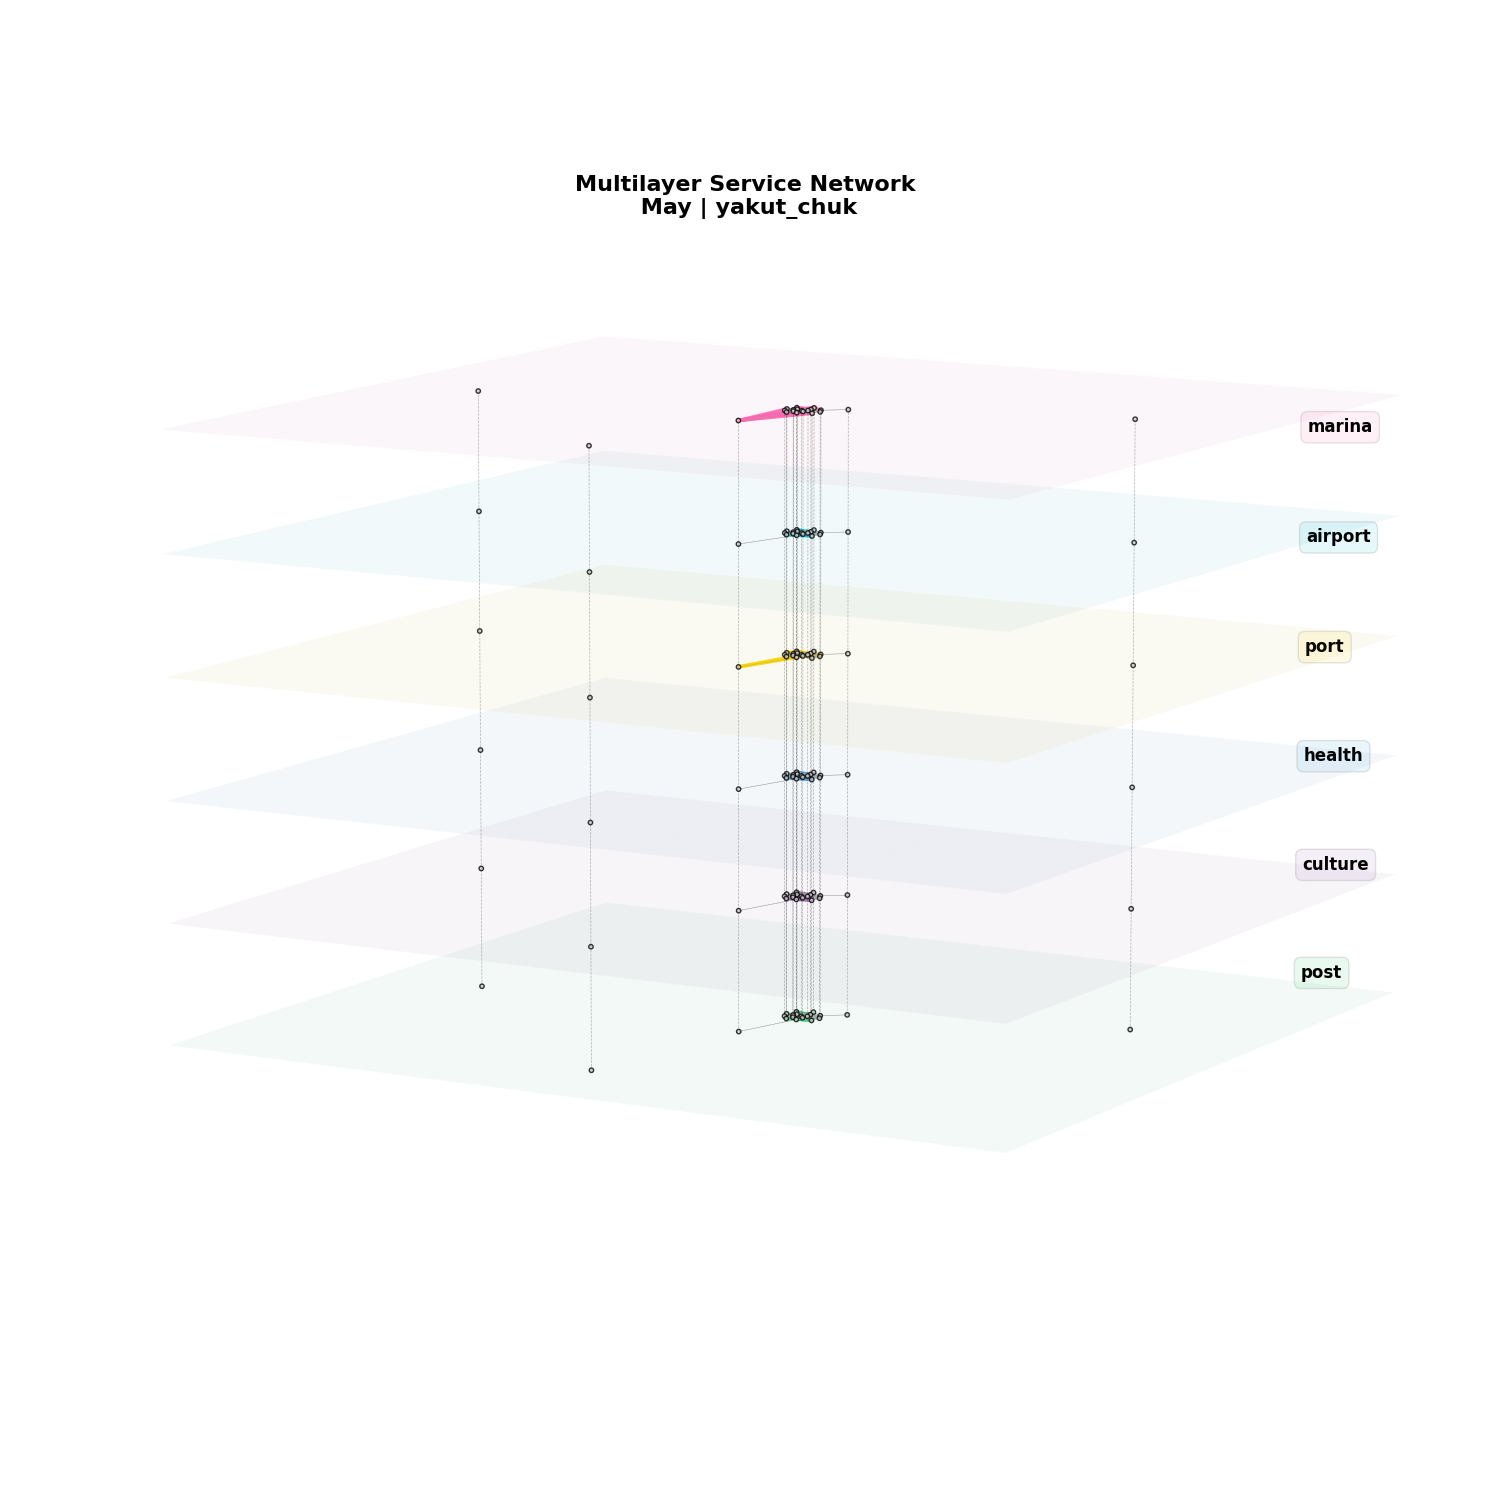

In [ ]:
from scripts.plotter.plotter_multilayer_service_network import plot_multilayer_network
from scripts.preprocesser.constants import month_order
import time

month = 4

# Example usage:
fig = plot_multilayer_network(
    all_results, SETTL_NAME, service_list, month=month, figsize=(15, 30)
)


# time.sleep(2)  # Pause to ensure the plot is rendered before saving
# plt.savefig(
#     f"../plots/multilayer_network_{SETTL_NAME}_{month_order[month]}.png",
#     bbox_inches="tight",
#     dpi=300,
# )


In [ ]:
from scripts.plotter.plotter_flow_sankey import create_clean_sankey

# Usage:
# Usage example:
for service in service_list:
    # try:
    month_start = 4
    end_month = 10
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    fig = create_clean_sankey(graphs, service_name=service, month_start=month_start)
    # except Exception as ex:
    # print(ex)

fig.show()


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Ostrovnoe', 'Omolon', 'Ojusardah', 'Jakutsk', 'Anjujsk', 'Kolymskoe', 'Cherskij', 'Keperveem', 'Pohodsk', 'Ilirnej', 'Andrjushkino', 'Ebjah', 'Argahtah', 'Magadan', 'Svataj', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Ostrovnoe', 'Omolon', 'Ojusardah', 'Jakutsk', 'Anjujsk', 'Kolymskoe', 'Cherskij', 'Keperveem', 'Pohodsk', 'Ilirnej', 'Andrjushkino', 'Ebjah', 'Argahtah', 'Magadan', 'Svataj', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Ostrovnoe', 'Omolon', 'Ojusardah', 'Jakutsk', 'Anjujsk', 'Kolymskoe', 'Cherskij', 'Keperveem', 'Pohodsk', 'Ilirnej', 'Andrjushkino', 'Ebjah', 'Argahtah', 'Magadan', 'Svataj', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 9 self-sufficient settlements: ['Ermolovo', 'Jakutsk', 'Anjujsk', 'Kolymskoe', 'Cherskij', 'Pohodsk', 'Magadan', 'Dve Viski', 'Nizhnekolymsk']
Found 12 consumers
T1: 7 assignments, 5 no provider
T2: 7 assignments, 5 no provider
T3: 6 assignments, 6 no provider
T4: 4 assignments, 8 no provider
T5: 12 assignments, 0 no provider
T6: 7 assignments, 5 no provider
Created 34 nodes
Created 72 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Ostrovnoe', 'Omolon', 'Ojusardah', 'Jakutsk', 'Anjujsk', 'Kolymskoe', 'Cherskij', 'Keperveem', 'Pohodsk', 'Ilirnej', 'Andrjushkino', 'Ebjah', 'Argahtah', 'Magadan', 'Svataj', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 4 self-sufficient settlements: ['Cherskij', 'Magadan', 'Jakutsk', 'Anjujsk']
Found 17 consumers
T1: 14 assignments, 3 no provider
T2: 6 assignments, 11 no provider
T3: 6 assignments, 11 no provider
T4: 5 assignments, 12 no provider
T5: 17 assignments, 0 no provider
T6: 14 assignments, 3 no provider
Created 36 nodes
Created 102 flows


In [ ]:
from scripts.plotter.plotter_circular_network_sankey_style import (
    plot_circular_network_sankey_style,
)
from scripts.preprocesser.constants import month_order

for service in service_list:
    print(service)
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    for i, g in enumerate(graphs):
        fig = plot_circular_network_sankey_style(
            g,
            service_name=service,
            month_name=month_order[month_start + i],
        )
        fig.show()
    print("=" * 10)


post


culture


health


port


airport


marina


In [ ]:
from scripts.plotter.plotter_multi_temporal_nx_plots import (
    plot_temporal_service_evolution,
    calculate_temporal_metrics,
    plot_temporal_metrics,
)


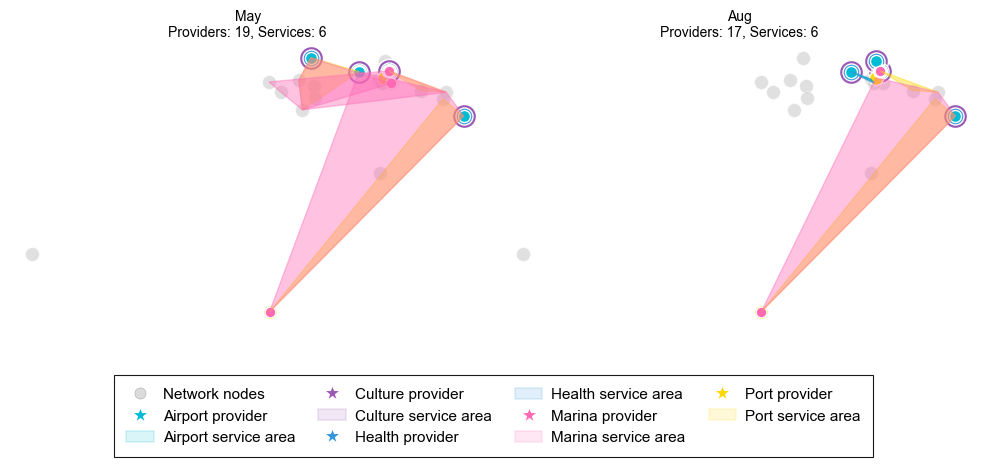

In [ ]:
MONTH_RANGE = range(4, 8, 3)  # May to October (indices 4-9)
results = plot_temporal_service_evolution(all_results, SETTL_NAME, MONTH_RANGE)


/Users/test/Documents/code/iccs25/scripts/plotter/plotter_multi_temporal_nx_plots.py:227: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



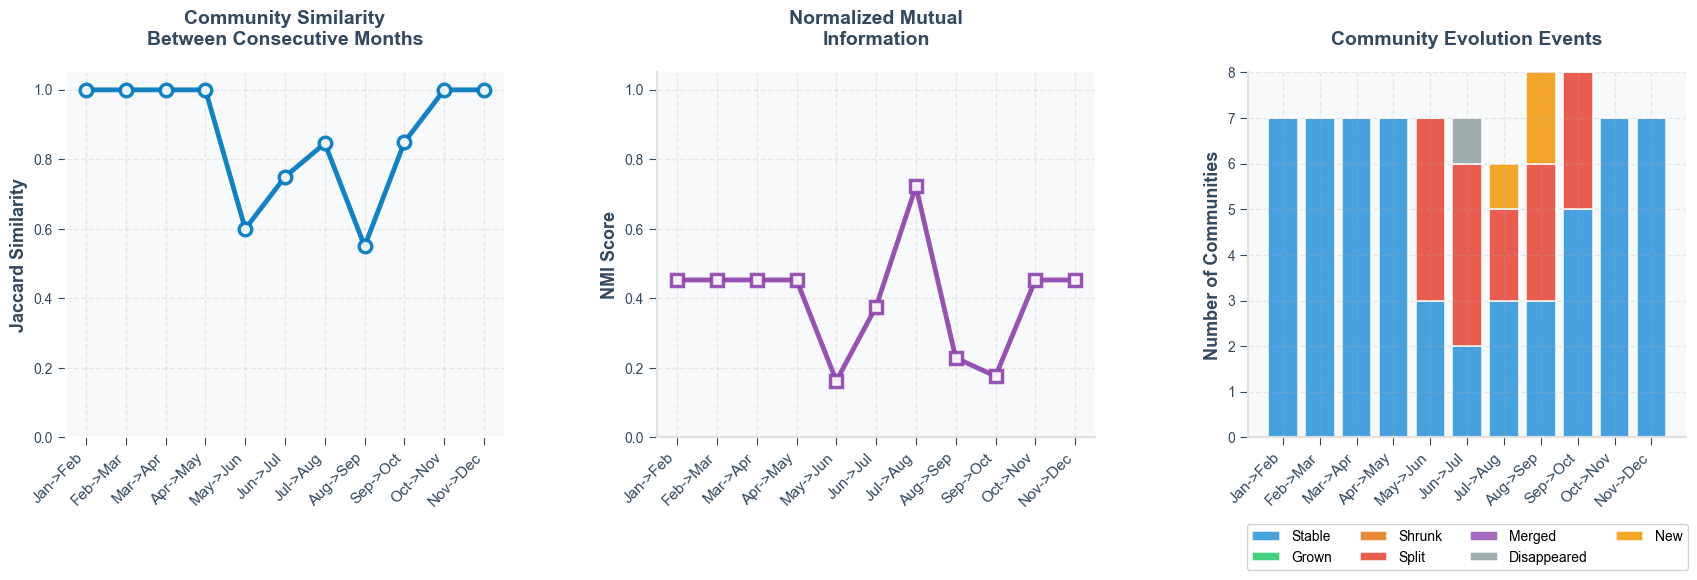

In [28]:
MONTH_RANGE = range(12)  # May to October (indices 4-9)
metrics, communities = calculate_temporal_metrics(all_results, SETTL_NAME, MONTH_RANGE)
_ = plot_temporal_metrics(metrics, communities)
